In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [3]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Sowmya"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Sowmya"))
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Sowmya

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Sowmya

I want to learn python programming language


In [4]:
### Chat Models

from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='That\'s a great choice! Python is a versatile and widely-used programming language that is great for beginners and also has powerful libraries for data science, web development, automation, and more. Here’s a suggested plan to help you get started with learning Python:\n\n1. **Set Up Your Environment:**\n   - Download and install Python from the [official website](https://www.python.org/downloads/).\n   - Install an Integrated Development Environment (IDE) or a code editor like [PyCharm](https://www.jetbrains.com/pycharm/), [Visual Studio Code](https://code.visualstudio.com/), or even Jupyter Notebook for data science projects.\n\n2. **Understand the Basics:**\n   - Learn the syntax and basic constructs of Python, including variables, data types, operators, and basic input/output operations.\n   - Explore control structures: conditionals (if statements), loops (for and while loops).\n\n3. **Work with Data Structures:**\n   - Get comfortable with Python’s built-in dat

In [5]:
### Tools

def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
           int
    """
    return a+b


In [13]:
### Binding tool with llm

llm_with_tools=llm.bind_tools([add])
tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="Sowmya")])

In [15]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'call_KgCG9i3mGpZVnYav4wEaydXl',
  'type': 'tool_call'}]

In [16]:
### Using messages as state

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
class State(TypedDict):
    message:list[AnyMessage]

In [18]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [19]:
### Reducers with add_messages
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Sowmya"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Sowmya')]

In [20]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [21]:
### Reducers add_messages is to append instead of override\n",
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='670c3924-84b4-4b65-a8b8-13d35ef20604'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Sowmya', id='4fdd5692-b6f5-494b-91fd-2ce7be55c6c6'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='2bbbbebe-b003-4611-a98a-b753d8ee4aaf')]

In [22]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

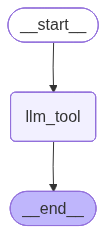

In [23]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)
builder.add_node("llm_tool",llm_tool)
builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
## invocation
messages=graph.invoke({"messages":"What is 2 plus 2"})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (call_aSKGeZskMS1xYhXcDsmG6Qi3)
 Call ID: call_aSKGeZskMS1xYhXcDsmG6Qi3
  Args:
    a: 2
    b: 2


In [26]:
tools=[add]
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
builder=StateGraph(State)
## Add nodes
builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))
## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
   "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
       tools_condition
)
builder.add_edge("tools",END)
graph_builder = builder.compile()

In [27]:
## invocation
messages=graph.invoke({"messages":"What is 2 plus 2"})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (call_gmcLwKU5HtMbRABL9VlNW2Q5)
 Call ID: call_gmcLwKU5HtMbRABL9VlNW2Q5
  Args:
    a: 2
    b: 2


In [28]:
messages=graph.invoke({"messages":"What Machine Learning"})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What Machine Learning
================================== Ai Message ==================================

It seems like your question might be incomplete or unclear. Are you asking about what machine learning is, how it works, its applications, or something else related to machine learning? Could you provide a bit more context or specify your query?
